In [1]:
using Pkg
Pkg.activate("geordd"; shared=true)

"/Users/imolk/Library/Julia/environments/geordd/Project.toml"

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\vvec}{\mathbf{v}}
    \newcommand{\yvec}{\mathbf{y}}
    \newcommand{\muvec}{\mathbf{\mu}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\mathcal{B}}
    \newcommand{\sentinels}{\mathbf{b}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\tauw}{\tau^{w}}
    \newcommand{\unifavg}{\tau^{\mathrm{UNIF}}}
    \newcommand{\invvar}{\tau^{\mathrm{INV}}}
    \newcommand{\taurho}{\tau^{\rho}}
    \newcommand{\tauproj}{\tau^{\mathrm{PROJ}}}
    \newcommand{\taugeo}{\tau^{\mathrm{GEO}}}
    \newcommand{\taupop}{\tau^{\mathrm{POP}}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
    % NYC %
    \newcommand{\saleprice}{\mathtt{SalePrice}}
    \newcommand{\sqft}{\mathtt{SQFT}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\dvec}{\mathbf{d}}
    \newcommand{\tax}{\mathtt{TaxClass}}
    \newcommand{\building}{\mathtt{BuildingClass}}
    \newcommand{\district}{\mathtt{District}}
    \newcommand{\eqlabel}[1]{\label{#1}}
    %\renewcommand{\eqref}[1]{(\verbß#1ß)}
    \DeclareMathOperator{\proj}{proj}
    \DeclareMathOperator{\dif}{d}
    \newcommand{\taubold}{\mathbf{\tau}}
$$

The New York City school district is itself divided into sub-districts. From now on, by “district”, I will be talking about these sub-districts. Residents are guaranteed a slot in a school within their district, but there is some system whereby a child can apply to attend schools outside of the district, which might possibly dampen the treatment effect.

Our goal is to detect discontinuities in the price of housing across the school district boundaries.

In [2]:
do_savefig = true
figures_dir = "/Users/imolk/Documents/Harvard/Miratrix/rdd-coverage/Maxime/manuscript/submissions/BNP NIPS 2018/figures"
;

In [3]:
using GaussianProcesses
using DataFrames
using Statistics
using Distributions
using LinearAlgebra
using Distances
using GeoJSON
using LibGEOS
using Optim
using GLM
import MultivariateStats
import StatsModels
import StatsBase
using Statistics
using Printf
using Random

using LaTeXStrings
using Formatting
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=150.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=150.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/GeoJSON/l1tgg.ji for GeoJSON [61d90e0f-e114-555e-ac52-39dfb47a3ef9]
└ @ Base loading.jl:1185
┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/compiled/v0.7/Formatting/vCa4N.ji for Formatting [59287772-0a20-5a39-b81b-1366585eb4c0]
└ @ Base loading.jl:1185


In [4]:
using Revise
using GeoRDD

# Dataset and Preprocessing

In [37]:
module NYC
    import GeoRDD
    using Statistics
    using Printf
    NYC_dir = joinpath(dirname(pathof(GeoRDD)), "../examples", "NYC")
    include(joinpath(NYC_dir, "NYC.jl"))
    using PyCall
    pushfirst!(PyVector(pyimport("sys")["path"]), NYC_dir)
    @PyCall.pyimport NYC_prepare_plots
    background_schdistrs = NYC_prepare_plots.background_schdistrs
    include(joinpath(NYC_dir, "NYCPlots.jl"))
end

Main.NYC

In [6]:
data_dir = joinpath(NYC.NYC_dir, "NYC_data")
schdistr_shape_dict = NYC.read_distr_shapes(; data_dir=data_dir)
NYC_sales = NYC.read_processed_sales(; data_dir=data_dir)
filtered = NYC.filter_sales(NYC_sales)
;
# # sentinels = NYC.read_sentinels()

# model_dicts = NYC.sales_dicts(filtered[:filtered])
# schdistr_indices = model_dicts[:schdistr_indices]
# schdistrs = model_dicts[:schdistrs]
# X_dict = model_dicts[:X_dict]
# Y_dict = model_dicts[:Y_dict]
# ;

┌ Warning: `convert(::Type{Symbol}, s::AbstractString)` is deprecated, use `Symbol(s)` instead.
│   caller = setindex! at array.jl:769 [inlined]
└ @ Core ./array.jl:769


## border

In [7]:
res = [NYC.RESIDENTIAL_DICT[v] for v in NYC_sales[NYC.BUILDING_CLASS_CATEGORY]]
sqft = .!ismissing.(NYC_sales[NYC.SQFT])
missing_sqft = NYC_sales[res .& .!sqft, :]
size(missing_sqft)

(27401, 17)

New York publishes a year's worth of house sales on a rolling basis. Annoyingly, this means that data that is older than a year disappears, and I've not been able to find this data online. But New York is a density, so even just a year's data is quite a large dataset.

I also have some covariates, though somewhat less rich than I found in Tucson. What I have is square footage, tax class and [building class](http://nycprop.nyc.gov/nycproperty/help/hlpbldgcode.html). I've geocoded the address of each sale to get a latitude and longitude, and projected the coordinates onto a Euclidean plane in order to be able to calculate distances.

![sales map](NYC_plots/NYC_sales.png)

## Data cleaning

I remove the following sales:

* any sale with missing data in the sale price, square footage, property covariates, geographical coordinates (due to failed geocoding)
* sales outside of any NYC school district
* properties smaller than 100 sq ft
* outliers in the price per sqft, which I defined as sales outside of $3 < Y_i < 7$

I remove tiny properties because I feel like they might behave differently than the rest of the market.
Removing outliers is possibly contentious, but it makes sense to me that some sales between friends or family members could have a very low $Y_i$ that isn't a true representation of the market price, and that some high prices could be equally disconnected from the market.

This leaves {{sum(filtered[:believable])}} out of {{length(filtered[:believable])}} sales records in NYC, mostly because of properties that don't have a reported gross square footage.

## map of all sales

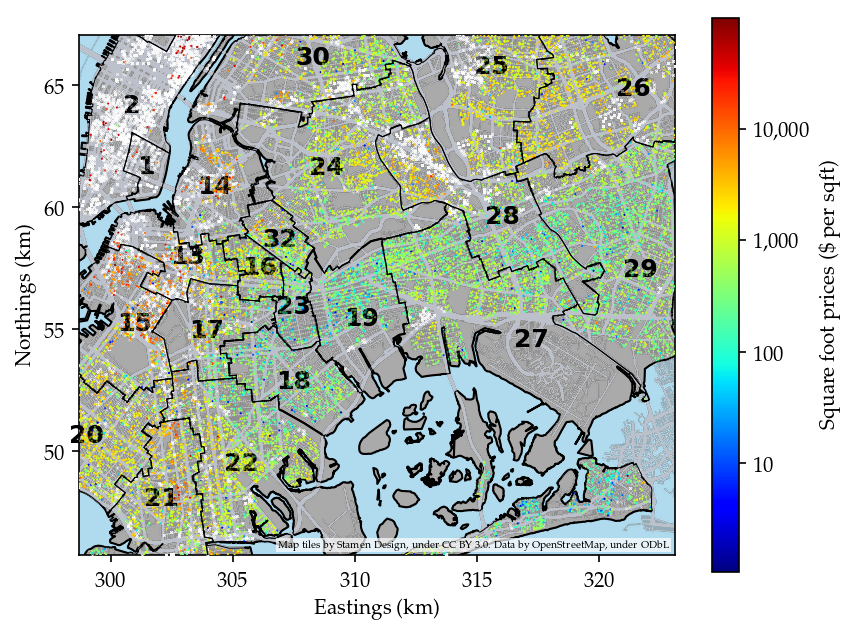

In [10]:
NYC.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204))
plt.text(0.99, 0.01, "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL",
    horizontalalignment="right",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca()[:transAxes], zorder=42)
if do_savefig
    plt.savefig(joinpath(figures_dir, "sales_map.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "sales_map.png"), bbox_inches="tight")
end
;

In [11]:
StatsBase.countmap(filtered[:filtered][NYC.BUILDING_CLASS_CATEGORY])

Dict{Union{Missing, CategoricalString{UInt32}},Int64} with 3 entries:
  CategoricalString{UInt32} "01  ONE FAMILY DWELLINGS"   => 8729
  CategoricalString{UInt32} "02  TWO FAMILY DWELLINGS"   => 8494
  CategoricalString{UInt32} "03  THREE FAMILY DWELLINGS" => 2355

In [12]:
# COUNTS OF
# BUILDING CLASS AT TIME OF SALE
# IN FILTERED DATA

building_class_dict = Dict{String,String}()
filename = joinpath(data_dir, "building_tax_class.txt")
open(filename) do io
    while true
        line = readline(io)
        line == "" && break
        code = strip(line[1:7])
        @assert length(code) == 2
        description = strip(line[8:end])
        building_class_dict[code] = description
   end
end
building_class_dict

description_count = Dict{String,Int}()
code_count = StatsBase.countmap(filtered[:filtered][NYC.BUILDING_CLASS_AT_TIME_OF_SALE])
for code in keys(code_count)
    description = building_class_dict[code]
    count = code_count[code]
    description_count[code*": "*description] = count
end
description_count

Dict{String,Int64} with 18 entries:
  "A4: CITY RESIDENCE ONE FAMILY"                   => 163
  "A1: TWO STORIES - DETACHED SM OR MID"            => 3559
  "S1: PRIMARILY 1 FAMILY WITH 1 STORE OR OFFICE"   => 197
  "A9: MISCELLANEOUS ONE FAMILY"                    => 753
  "B1: TWO FAMILY BRICK"                            => 2712
  "B9: MISCELLANEOUS TWO FAMILY"                    => 741
  "A7: MANSION TYPE OR TOWN HOUSE"                  => 4
  "A0: CAPE COD"                                    => 232
  "B3: TWO FAMILY CONVERTED FROM ONE FAMILY"        => 2277
  "S0: PRIMARILY 1 FAMILY WITH 2 STORES OR OFFICES" => 10
  "A3: LARGE SUBURBAN RESIDENCE"                    => 140
  "A6: SUMMER COTTAGE"                              => 30
  "C0: THREE FAMILIES"                              => 2355
  "S2: PRIMARILY 2 FAMILY WITH 1 STORE OR OFFICE"   => 432
  "B2: TWO FAMILY FRAME"                            => 2332
  "A2: ONE STORY - PERMANENT LIVING QUARTER"        => 1255
  "A5: ONE FAMILY 

In [13]:
StatsBase.countmap(missing_sqft[NYC.BUILDING_CLASS_CATEGORY])

Dict{Union{Missing, CategoricalString{UInt32}},Int64} with 9 entries:
  CategoricalString{UInt32} "15  CONDOS - 2-10 UNIT RESIDENTIAL" => 963
  CategoricalString{UInt32} "12  CONDOS - WALKUP APARTMENTS"     => 557
  CategoricalString{UInt32} "01  ONE FAMILY DWELLINGS"           => 3
  CategoricalString{UInt32} "10  COOPS - ELEVATOR APARTMENTS"    => 11846
  CategoricalString{UInt32} "09  COOPS - WALKUP APARTMENTS"      => 2480
  CategoricalString{UInt32} "17  CONDO COOPS"                    => 1292
  CategoricalString{UInt32} "04  TAX CLASS 1 CONDOS"             => 781
  CategoricalString{UInt32} "02  TWO FAMILY DWELLINGS"           => 1
  CategoricalString{UInt32} "13  CONDOS - ELEVATOR APARTMENTS"   => 9478

# Model

I decided to define the outcome to be the log price per square foot. The model is a Gaussian Process in the spatial covariates on top of a ridge regression on the property covariates (building and tax class). Within a school district we could write the model as [suggestions for clearer notation welcome]:

\begin{equation}
\begin{split}
    Y_i &= \log\del{ \frac{\saleprice_i}{\sqft_i}} =
             \mu_{\district\sbr{i}} + \beta_{1,\tax\sbr{i}} + \beta_{2,\building\sbr{i}}
                  + f_{\district\sbr{i}}(\svec_i) + \epsilon_i
    \\
    \epsilon_i &\sim \normal\del{0, \sigma_y^2} \\
    \mu_{j} &\sim \normal\del{0, \sigma_\mu^2} \\
    \beta_{1j},\beta_{2j} &\sim \normal\del{0, \sigma_\beta^2} \\
    f_j(\svec_i) &\sim \gp\del{0, k(\svec, \svec')} \\
    k(\svec, \svec') &= \sigmaf^2 \exp\cbr{ - \frac{(\svec-\svec')\trans(\svec-\svec')}{2\ell^2}}
\end{split}
\end{equation}

A visual inspection of the house sales map above led me to focus on the boundary between districts 19 and 27. I found a map online of average maths performance in each school district, which shows that districts 19 and 27 are quite different. It's important to note that the boundary between the two districts is also part of the boundary between Brooklyn and Queens, so we won't be able to attribute a causal effect solely to the difference in school districts. A histogram of $Y$ in both districts also shows that marginally the house prices are very different.

![districts](NYC_plots/NYC_school_performances_croppped.png)

In [14]:
fmla = @formula(logSalePricePerSQFT ~ GP(XCoord, YCoord) | SchDistr + BUILDING)

geordd_df = filtered[:filtered][[:logSalePricePerSQFT, :SchDistr, :XCoord, :YCoord]]
geordd_df[:BUILDING] = filtered[:filtered][NYC.BUILDING_CLASS_AT_TIME_OF_SALE]
geordd_df[:TAX] = filtered[:filtered][NYC.TAX_CLASS_AT_TIME_OF_SALE]
nyc_rd = GeoRDD.regions_from_dataframe(fmla, geordd_df);
# assign shapes
for distr in keys(nyc_rd)
    nyc_rd[distr].shape = schdistr_shape_dict[distr]
end

In [15]:
# k_mgpcv = SEIso(log(2000.0), log(1.0))
k_mgpcv = Mat12Iso(log(2000.0), log(1.0))
k_wmean = k_mgpcv + GaussianProcesses.fix(Const(log(20.0)))
βkern = LinIso(log(1.0))
local_distrs = [18,19,23,24,25,26,27,28,29]
mgpcv = GeoRDD.MultiGPCovars(nyc_rd, local_distrs, k_wmean, βkern, log(1.0))
;

## histogram of districts 19 and 27

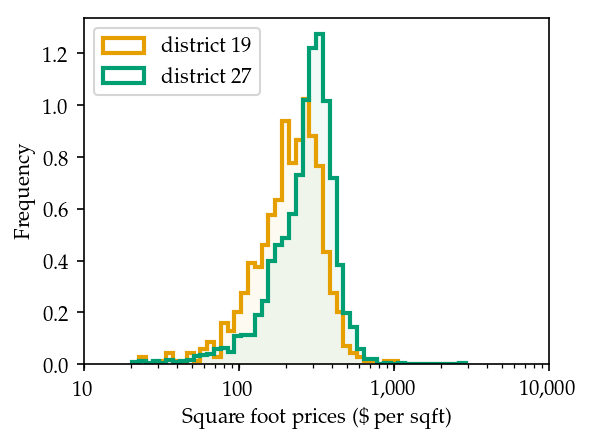

In [16]:
let 
    distrA = 19
    distrB = 27
    Y_A = nyc_rd[distrA].y
    Y_B = nyc_rd[distrB].y
    minY = min(minimum(Y_A), minimum(Y_B))
    maxY = max(maximum(Y_B), maximum(Y_A))
    Ybins = range(minY, stop=maxY, length=50)
    plt.plt[:hist](Y_A, 
        bins=Ybins, 
        histtype="step", 
        label=@sprintf("district %d", distrA), 
        normed=true,
        color=cbbPalette[1],
        alpha=1.0,
        linewidth=2)
    plt.plt[:hist](Y_A, 
        bins=Ybins, 
        histtype="stepfilled", 
        normed=true,
        color=cbbPalette[1],
        alpha=0.05,
        zorder=-1,
        linewidth=0)
    plt.plt[:hist](Y_B, 
        bins=Ybins, 
        histtype="step", 
        label=@sprintf("district %d", distrB), 
        normed=true,
        color=cbbPalette[3],
        alpha=1.0,
        linewidth=2)
    plt.plt[:hist](Y_B, 
        bins=Ybins, 
        histtype="stepfilled",  
        normed=true,
        color=cbbPalette[3],
        alpha=0.05,
        zorder=-1,
        linewidth=2)
end
plt.xlabel("Square foot prices (\\\$ per sqft)")
plt.ylabel("Frequency")
plt.legend(loc="upper left")
tick_template = [1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.gca()[:set_xticks](log.([10, 100, 1000, 10000]))
plt.gca()[:set_xticks](log.([tick_template.*10; tick_template.*100; tick_template.*1000]), 
                       minor=true)
plt.gcf()[:set_size_inches](4.0, 3.0)
plt.gca()[:set_xticklabels]([format(x, commas=true) for x in [10, 100, 1000, 10000]])
if do_savefig
    plt.savefig(joinpath(figures_dir, "sales_histogram_19-27.pdf"), bbox_inches="tight", transparent=true)
    plt.savefig(joinpath(figures_dir, "sales_histogram_19-27.png"), bbox_inches="tight", transparent=true)
end
;

# Fitting the Gaussian process model

In [17]:
# takes 1 hour for 100 iterations
GeoRDD.set_params!(mgpcv, 
        [-0.911291, 8.40782, -1.63192, 1.92312], # output of optim w/ SEIso kernel
        noise=true,
        kern=true,
        domean=false,
        beta=true
        )
GeoRDD.update_mll!(mgpcv)
;

In [18]:
set_params!(mgpcv, [-0.925424, 9.69509, -1.33042, 1.9309])
GeoRDD.update_mll!(mgpcv)

-5579.642964543864

In [19]:
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        kern=true,
        domean=false,
        beta=true,
        options=Optim.Options(
            show_trace=true,
            iterations=1000,
            x_tol=1e-8,
            f_tol=1e-10),
    )
opt_output

Iter     Function value   Gradient norm 
     0     5.579643e+03     1.251140e-01
     1     5.579643e+03     1.439809e-02
 96.874352 seconds (7.08 M allocations: 1.176 GiB, 0.37% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-0.925424,9.69509,-1.33042,1.9309]
 * Minimizer: [-0.9254302690845536,9.69508994179876, ...]
 * Minimum: 5.579643e+03
 * Iterations: 1
 * Convergence: true
   * |x - x'| ≤ 1.0e-08: false 
     |x - x'| = 6.27e-06 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 7.24e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.44e-02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 3
 * Gradient Calls: 3

In [20]:
print(GeoRDD.get_params(mgpcv; domean=false))

[-0.92543, 9.69509, -1.33042, 1.9309]

In [21]:
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
@printf("σ_f: %.4f\n", √(mgpcv.kernel.kleft.σ2))
@printf("σ_β: %.4f\n", 1/√mgpcv.βkern.ℓ2)
@printf("ℓ: %.4f ft\n", (mgpcv.kernel.kleft.ℓ))
@printf("ℓ: %.4f km\n", (mgpcv.kernel.kleft.ℓ) / 3280.84)

σ_y: 0.3964
σ_f: 0.2644
σ_β: 0.1450
ℓ: 16237.6832 ft
ℓ: 4.9492 km


In [22]:
ℓ = mgpcv.kernel.kleft.ℓ

16237.683173346366

## Kernel comparison

Type: SEIso{Float64}, Params: [8.4079, -1.63199]


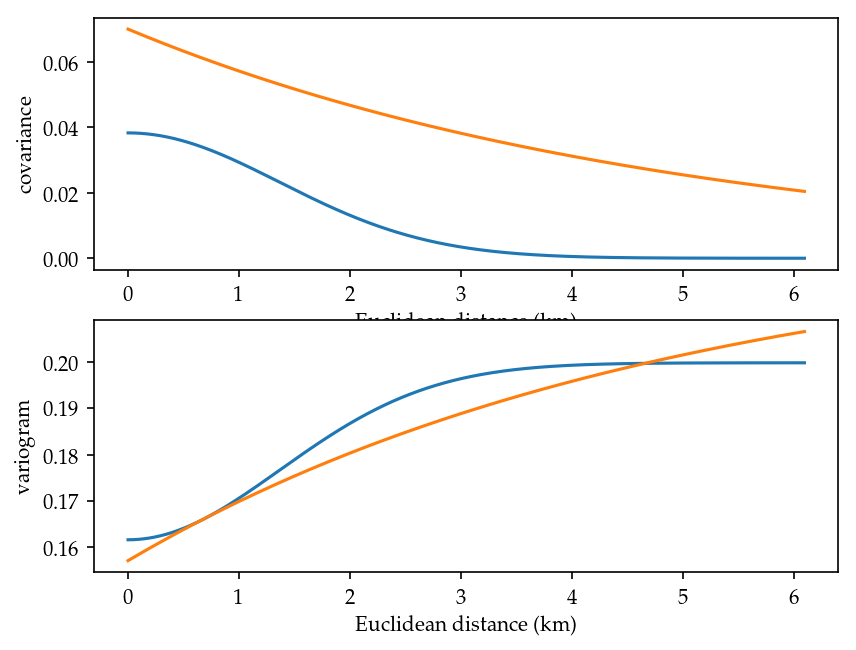

┌ Warning: broadcast will default to iterating over its arguments in the future. Wrap arguments of
│ type `x::SEIso{Float64}` with `Ref(x)` to ensure they broadcast as "scalar" elements.
│   caller = ip:0x0
└ @ Core :-1


In [23]:
let
    k_se = SEIso(log(2000.0), log(1.0))
    hyp_se = [-0.911291, 8.4079, -1.63199, 1.92018]
    GeoRDD.set_params!(k_se, hyp_se[2:3])
    println(k_se)
    rr = range(0, stop=20000, length=1000)
    plt.subplot(2,1,1)
    plt.plot(rr.*0.0003048, cov.(k_se, rr.^2))
    plt.plot(rr.*0.0003048, cov.(k_mgpcv, rr))
    plt.ylabel("covariance")
    plt.xlabel("Euclidean distance (km)")
    
    function variog(k, logNoise)
        cov_r = [cov(k, [0.0,r,0.0], [0.0,0.0,0.0]) for r in rr]
        return exp(2.0*logNoise)+cov_r[1].-cov_r
    end
    plt.subplot(2,1,2)
    plt.plot(rr.*0.0003048, variog(k_se, hyp_se[1]))
    plt.plot(rr.*0.0003048, variog(k_mgpcv, mgpcv.logNoise))
    plt.ylabel("variogram")
    plt.xlabel("Euclidean distance (km)")
end
;

## Get posterior mean $\beta$ using multiple districts

In [24]:
@time βhat = GeoRDD.postmean_β(mgpcv);
# βhat_dict=Dict(zip(coefnames(mf), βhat))

  7.088091 seconds (3.34 M allocations: 1.815 GiB, 3.89% gc time)


## Fit residuals with new $\hat\beta$ and hyperparameters

In [25]:
# obtain the residuals within each district
residuals_rd = empty(nyc_rd)
for key in keys(nyc_rd)
    residuals_rd[key] = GeoRDD.residuals_data(nyc_rd[key], βhat)
end

In [26]:
resid_GP_dict = GeoRDD.GPRealisations(residuals_rd, mgpcv.kernel, exp(mgpcv.logNoise))
;

# cliff-face

In [27]:
distrA,distrB=19,27
border = GeoRDD.get_border(nyc_rd[distrA], nyc_rd[distrB], 10.0)
sentinels = GeoRDD.sentinels(border, 100)
μpost, Σpost = GeoRDD.cliff_face(resid_GP_dict[distrA], 
                                 resid_GP_dict[distrB],
                                 sentinels)
;

┌ Warning: using `A[I...] = x` to implicitly broadcast `x` across many locations is deprecated. Use `A[I...] .= x` instead.
│   caller = best_orientation(::Array{Array{Array{Float64,1},1},1}) at geometry.jl:217
└ @ GeoRDD /Users/imolk/Documents/Harvard/Miratrix/GeoRDD/src/geometry.jl:217


In [28]:
# plotting convenience functions
function yaxis_right()
    ax = plt.gca()
    ax[:yaxis][:tick_right]()
    ax[:yaxis][:set_label_position]("right")
end
function title_in_axis(s, leftright)
    if leftright == :left
        plt.text(0.05, 0.95, s,
             horizontalalignment="left",
             verticalalignment="top",
             transform = plt.gca()[:transAxes])
    elseif leftright == :right
        plt.text(0.95, 0.95, s,
             horizontalalignment="right",
             verticalalignment="top",
             transform = plt.gca()[:transAxes])
    else
        throw("left or right?")
    end
end
function hide_xaxis()
    plt.gca()[:xaxis][:set_ticklabels]([])
    plt.xlabel("")
end
;

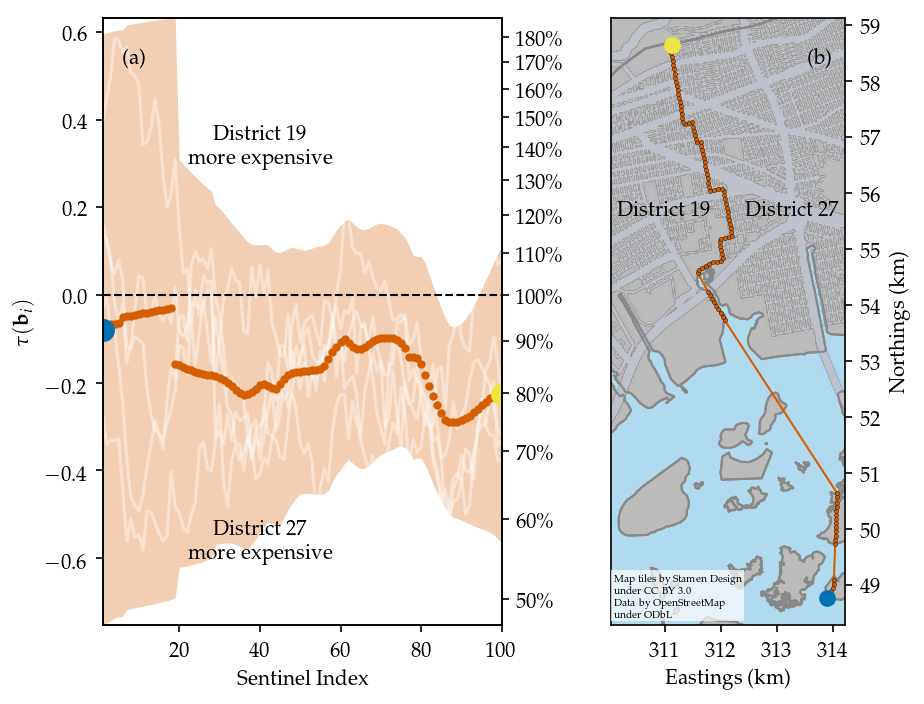

In [29]:
distrA = 19
distrB = 27
msize = 7 # size of first sentinel / last sentinel marker
PyPlot.plt[:interactive](true)
ax = plt.gca()
plt.subplot(1,2,2)

PyPlot.plt[:interactive](false)
plt.plot(sentinels[1,:], sentinels[2,:], linewidth=1, 
        linestyle="-", marker="o", 
        markeredgecolor="black",
        markeredgewidth=0.2,
        markersize=2, 
        color=cbbPalette[6])
plt.plot(sentinels[1,1], sentinels[2,1], "o", color=cbbPalette[5], markersize=msize, label="first point")
plt.plot(sentinels[1,end], sentinels[2,end], "o", color=cbbPalette[4], markersize=msize, label="last point")
plt.text(sentinels[1,50]+1000,sentinels[2,50], "District 27", horizontalalignment="left")
plt.text(sentinels[1,50]-1000,sentinels[2,50], "District 19", horizontalalignment="right")
ax[:set_aspect]("equal")
plt.xlim(plt.xlim()[1]-3000,plt.xlim()[2])
_xlim = plt.xlim()
_ylim = plt.ylim()

NYC.background_schdistrs(plt.gca(),
            color="#BBBBBB", 
            edgecolor="#888888",
            alpha=1.0,
            linestyle="-",
            linewidth=1,
            zorder=-10
            )
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204), zorder=-8)
NYC.background_schdistrs(plt.gca(),
            color="none", 
            edgecolor="#888888",
            alpha=1.0,
            linestyle="-",
            linewidth=1,
            zorder=-6
            )
plt.text(0.01, 0.01, "Map tiles by Stamen Design\nunder CC BY 3.0\nData by OpenStreetMap\nunder ODbL",
    horizontalalignment="left",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca()[:transAxes], zorder=42)
plt.xlim(_xlim)
plt.ylim(_ylim)
NYC.ticks_km(1.0)
ax = plt.gca()
ax[:set_facecolor]("#B0DAEE")
ax[:yaxis][:tick_right]()
ax[:yaxis][:set_label_position]("right")

title_in_axis("(b)", :right)

### Cliff Face

plt.subplot(1,2,1)
# plt.title("Treatment Effect Cliff Face")
Random.seed!(2)
NYC.plot_cliffface(μpost,Σpost, cbbPalette[6]; ndraws=5)
plt.axhline(y=0, color="black", linewidth=1, linestyle="--")
plt.text(40, 0.3,  "District 19\nmore expensive", horizontalalignment="center")
plt.text(40, -0.6, "District 27\nmore expensive", horizontalalignment="center")
plt.ylabel(L"\tau(\mathbf{b}_i)")
plt.xlabel("Sentinel Index")
# plt.legend()
plt.tight_layout()
title_in_axis("(a)", :left)
PyPlot.plt[:interactive](true)
if do_savefig
    plt.savefig(joinpath(figures_dir, "NYC_cliff_face.pdf"), bbox_inches="tight", transparent=true)
    plt.savefig(joinpath(figures_dir, "NYC_cliff_face.png"), bbox_inches="tight", transparent=true)
end
;

## surface plot

In [30]:
distrA,distrB=19,27
border = GeoRDD.get_border(nyc_rd[distrA], nyc_rd[distrB], 10.0)
sentinels = GeoRDD.sentinels(border, 100)
gridspace= 200.0 # feet
gridA = GeoRDD.region_grid(schdistr_shape_dict[distrA], gridspace)
gridB = GeoRDD.region_grid(schdistr_shape_dict[distrB], gridspace)

gpA = resid_GP_dict[distrA]
gpB = resid_GP_dict[distrB]
predgridA=GaussianProcesses.predict_f(gpA, gridA; full_cov=false)[1]
predgridB=GaussianProcesses.predict_f(gpB, gridB; full_cov=false)[1]
predA_b = GaussianProcesses.predict_f(gpA, sentinels; full_cov=false)[1]
predB_b = GaussianProcesses.predict_f(gpB, sentinels; full_cov=false)[1]
;

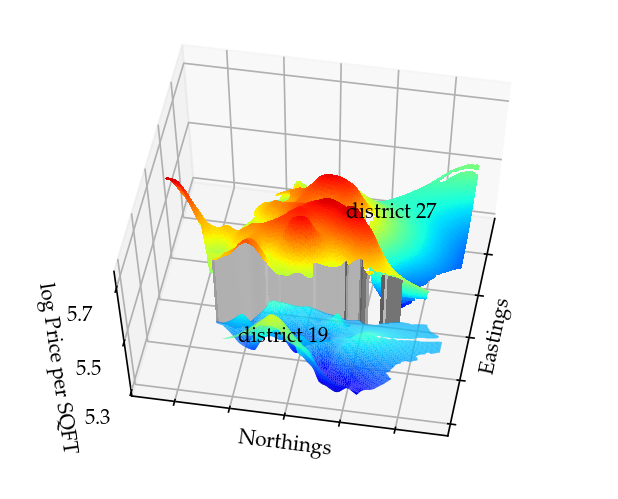

┌ Warning: `find(A::AbstractVector)` is deprecated, use `findall(A)` instead.
│   caller = #plot_surface3d#28(::Tuple{Float64,Float64}, ::Tuple{Float64,Float64}, ::String, ::String, ::Function, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,2}, ::MultiPolygon, ::MultiPolygon) at NYCPlots.jl:511
└ @ Main.NYC /Users/imolk/Documents/Harvard/Miratrix/GeoRDD/examples/NYC/NYCPlots.jl:511
┌ Warning: `mean(A::AbstractArray, dims)` is deprecated, use `mean(A, dims=dims)` instead.
│   caller = #plot_surface3d#28(::Tuple{Float64,Float64}, ::Tuple{Float64,Float64}, ::String, ::String, ::Function, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,2}, ::MultiPolygon, ::MultiPolygon) at NYCPlots.jl:527
└ @ Main.NYC /Users/imolk/Documents/Harvard/Miratrix/GeoRDD/examples/NYC/NYCPlots.jl:527
┌ Warning: `mean(A::AbstractArray, dims

In [38]:
plt.gcf()[:set_size_inches](5.0, 4.0)
NYC.plot_surface3d(gridA, gridB, predgridA, predgridB, predA_b, predB_b, 
               sentinels, 
               schdistr_shape_dict[distrA],
               schdistr_shape_dict[distrB];
               xlim=(1.000e6, 1.20e6),
               ylim=(0.172e6, 0.203e6),
               labelT="district 19",
               labelC="district 27"
               )
ax = plt.gca()
ax[:dist] = 10
ax[:xaxis][:labelpad] = -10.0
ax[:yaxis][:labelpad] = -10.0
ax[:zaxis][:labelpad] = 1.0
ax[:view_init](elev=60, azim=190)
if do_savefig
    plt.savefig(joinpath(figures_dir, "NYC_surface_plot.pdf"), bbox_inches="tight", transparent=true)
    plt.savefig(joinpath(figures_dir, "NYC_surface_plot.png"), bbox_inches="tight", transparent=true)
end

# Average treatment effect

## Unweighted mean treatment effect

In [67]:
τ_unif=GeoRDD.unweighted_mean(μpost, Σpost)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_unif), std(τ_unif))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_unif, 0.0)*100)

τ|Y ∼ Normal(μ=-0.158, σ=0.093)
P(τ>0|Y) = 4.516%

## Finite-population method

In [68]:
maxdist = 2ℓ
τpost_proj = GeoRDD.proj_estimator(resid_GP_dict[distrA], 
                                   resid_GP_dict[distrB], 
                                   border,
                                   2ℓ)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τpost_proj), std(τpost_proj))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τpost_proj, 0.0)*100)

τ|Y ∼ Normal(μ=-0.159, σ=0.093)
P(τ>0|Y) = 4.283%

## Inverse variance

In [33]:
τ_inv=GeoRDD.inverse_variance(μpost, Σpost)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_inv), std(τ_inv))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_inv, 0.0)*100)

τ|Y ∼ Normal(μ=-0.197, σ=0.063)
P(τ>0|Y) = 0.093%

In [35]:
exp(-mean(τ_inv))

1.2182666638094621

## Geographic projection estimator

In [116]:
distrA, distrB = 19, 27
border = GeoRDD.get_border(nyc_rd[distrA], nyc_rd[distrB], 10.0)
region = LibGEOS.union(schdistr_shape_dict[distrA], schdistr_shape_dict[distrB])
@time τ_geo = GeoRDD.infinite_proj_estim(resid_GP_dict[distrA], 
                                   resid_GP_dict[distrB], 
                                   border,
                                   region,
                                   2ℓ,
                                   ℓ/10,
                                   )
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_geo), std(τ_geo))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_geo, 0.0)*100)

 11.343708 seconds (358.56 k allocations: 22.980 MiB, 0.10% gc time)
τ|Y ∼ Normal(μ=-0.119, σ=0.164)
P(τ>0|Y) = 23.372%

## Population density

In [71]:
using KernelDensity

In [72]:
gp_T = resid_GP_dict[distrA]
gp_C = resid_GP_dict[distrB]
X_both = [gp_T.x gp_C.x]
kde_1927 = kde(X_both')
density_1927 = (s1,s2) -> pdf(kde_1927, s1, s2)
;

In [73]:
@time τ_pop = GeoRDD.infinite_proj_estim(resid_GP_dict[distrA], 
                                   resid_GP_dict[distrB], 
                                   border,
                                   region,
                                   2ℓ,
                                   ℓ/10
                                   ;
                                   density=density_1927
                                   )
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_pop), std(τ_pop))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_pop, 0.0)*100)

┌ Warning: `product(xss...)` is deprecated, use `Iterators.product(xss...)` instead.
│   caller = #infinite_proj_sentinels#59(::getfield(Main, Symbol("##13#14")), ::Function, ::GPE{Array{Float64,2},Array{Float64,1},MeanZero,SumKernel{Mat12Iso{Float64},FixedKernel{Const{Float64},0}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.PairData{GaussianProcesses.IsotropicData{Array{Float64,2}},GaussianProcesses.EmptyData}}, ::GPE{Array{Float64,2},Array{Float64,1},MeanZero,SumKernel{Mat12Iso{Float64},FixedKernel{Const{Float64},0}},PDMats.PDMat{Float64,Array{Float64,2}},GaussianProcesses.PairData{GaussianProcesses.IsotropicData{Array{Float64,2}},GaussianProcesses.EmptyData}}, ::MultiLineString, ::MultiPolygon, ::Float64, ::Float64) at border_projection.jl:63
└ @ GeoRDD /Users/imolk/Documents/Harvard/Miratrix/GeoRDD/src/border_projection.jl:63


 15.306235 seconds (5.38 M allocations: 891.080 MiB, 2.18% gc time)
τ|Y ∼ Normal(μ=-0.163, σ=0.086)
P(τ>0|Y) = 2.924%

## Border density

In [74]:
stnl_ρ = [density_1927(sentinels[1,i], sentinels[2,i]) for i in 1:size(sentinels,2)]
τ_rho = GeoRDD.weighted_mean(μpost, Σpost, stnl_ρ)
@printf("τ|Y ∼ Normal(μ=%.3f, σ=%.3f)\n", mean(τ_rho), std(τ_rho))
@printf("P(τ>0|Y) = %.3f%%", ccdf(τ_rho, 0.0)*100)

τ|Y ∼ Normal(μ=-0.192, σ=0.064)
P(τ>0|Y) = 0.141%

## Tables of Estimates

In [75]:
labels = [L"\unifavg", L"\taurho", L"\invvar", L"\tauproj", L"\taugeo", L"\taupop"]
estimators = [τ_unif, τ_rho, τ_inv, τpost_proj, τ_geo, τ_pop]
nyc_estimates = DataFrame()
nyc_estimates[:estimand] = labels
nyc_estimates[:mean] = [@sprintf("%.2f", mean(est)) for est in estimators]
nyc_estimates[:std] =  [@sprintf("%.2f", std(est)) for est in estimators]
nyc_estimates[:tail] = [@sprintf("%.2f%%", ccdf(est, 0.0)*100) for est in estimators]
nyc_estimates

,estimand,mean,std,tail
,LaTeXStr…,String,String,String
1,$\\unifavg$,-0.16,0.09,4.52%
2,$\\taurho$,-0.19,0.06,0.14%
3,$\\invvar$,-0.20,0.06,0.09%
4,$\\tauproj$,-0.16,0.09,4.28%
5,$\\taugeo$,-0.12,0.16,23.37%
6,$\\taupop$,-0.16,0.09,2.92%


In [81]:
print(repr("text/latex", nyc_estimates))

\begin{tabular}{r|cccc}
	& estimand & mean & std & tail\\
	\hline
	1 & $\unifavg$ & -0.16 & 0.09 & 4.52\% \\
	2 & $\taurho$ & -0.19 & 0.06 & 0.14\% \\
	3 & $\invvar$ & -0.20 & 0.06 & 0.09\% \\
	4 & $\tauproj$ & -0.16 & 0.09 & 4.28\% \\
	5 & $\taugeo$ & -0.12 & 0.16 & 23.37\% \\
	6 & $\taupop$ & -0.16 & 0.09 & 2.92\% \\
\end{tabular}


# Significance Tests

## $\chi^2$ bootstrap test

In [41]:
Random.seed!(1) # for replicability
distrA, distrB = 19, 27
@time pval_chi2 = GeoRDD.boot_chi2test(resid_GP_dict[distrA], resid_GP_dict[distrB],
                     sentinels,
                     10000) # number of bootstrap samples

UndefVarError: UndefVarError: resid_GP_dict not defined

## mll bootstrap test

In [41]:
srand(1) # for replicability
distrA, distrB = 19, 27
@time pval_mll = GeoRDD.boot_mlltest(
    resid_GP_dict[distrA],
    resid_GP_dict[distrB],
    10000 # number of bootstrap samples
)

Add `using Random` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
┌ Warning: `srand` is deprecated, use `Random.seed!` instead.
│   caller = top-level scope at In[41]:1
└ @ Core In[41]:1


UndefVarError: UndefVarError: resid_GP_dict not defined

## inv-var test

In [49]:
pval_invvar_calib = GeoRDD.pval_invvar_calib(
    resid_GP_dict[distrA],
    resid_GP_dict[distrB],
    sentinels
)

0.004853613805822872

In [50]:
# uncalibrated
GeoRDD.pval_invvar(
    resid_GP_dict[distrA],
    resid_GP_dict[distrB],
    sentinels
)

0.0018568270815754466

## Placebos

In [44]:
function plot_placebo_pval_hist(pvalA, pvalB, pval_obs; plot_obs=true, label_unif=true)
    bins = range(0, stop=1, length=10)
    plt.plt[:hist](pvalA, bins=bins, linewidth=2, 
        color=cbbPalette[1], label=@sprintf("district %s", distrA), 
        histtype="step",
        alpha=1.0,
        )
    plt.plt[:hist](pvalB, bins=bins, linewidth=2, 
        color=cbbPalette[2], label=@sprintf("district %s", distrB), 
        alpha=1.0,
        histtype="step",
        )
    plt.plt[:hist](pvalA, bins=bins, linewidth=0, 
        color=cbbPalette[1],
        histtype="stepfilled",
        alpha=0.05,
        zorder=-1,
        )
    plt.plt[:hist](pvalB, bins=bins, linewidth=0, 
        color=cbbPalette[2],
        alpha=0.05,
        zorder=-1,
        histtype="stepfilled",
        )
    if plot_obs
        plt.axvline(pval_obs, color=cbbPalette[3], label="observed", linewidth=3)
    end
    plt.axhline(length(pvalB)/length(bins), color="#333333", linestyle="--")
    if label_unif
        plt.text(y=length(pvalB)/length(bins) + 0.1, 
                 x=0.02,
                 s="Uniform",
                 color="#333333",
                 horizontalalignment="left",
                 verticalalignment="bottom",
                 rotation=0)
    end
    plt.xlabel("p-value")
    plt.ylabel("Count")
    plt.xlim(0,1)
end
function plot_placebo_pval_horiz_hist(pvalA, pvalB, pval_obs; plot_obs=true, label_unif=true)
    bins = linspace(0,1,10)
    plt.plt[:hist](pvalA, bins=bins, linewidth=2, 
        color=cbbPalette[1], label=@sprintf("district %s", distrA), 
        alpha=1.0,
        histtype="step",
        orientation="horizontal",
        )
    plt.plt[:hist](pvalB, bins=bins, linewidth=2, 
        color=cbbPalette[2], label=@sprintf("district %s", distrB), 
        alpha=1.0,
        histtype="step",
        orientation="horizontal"
        )
    plt.plt[:hist](pvalA, bins=bins, linewidth=0, 
        color=cbbPalette[1], 
        alpha=0.05,
        histtype="stepfilled",
        zorder=-1,
        orientation="horizontal",
        )
    plt.plt[:hist](pvalB, bins=bins, linewidth=0, 
        color=cbbPalette[2],
        alpha=0.05,
        histtype="stepfilled",
        zorder=-1,
        orientation="horizontal"
        )
    if plot_obs
        plt.axhline(pval_obs, color=cbbPalette[3], label="observed", linewidth=3)
    end
    plt.axvline(length(pvalB)/length(bins), color="#333333", linestyle="-")
    if label_unif
        plt.text(x=length(pvalB)/length(bins) + 0.1, 
                 y=0.98,
                 s="Uniform",
                 color="#333333",
                 horizontalalignment="left",
                 verticalalignment="top",
                 rotation=-90)
    end
    plt.ylabel("p-value")
    plt.xlabel("Count")
    plt.ylim(0,1)
end
function plot_placebo_pval_trace(x_angle, pvalA, pvalB, pval_obs; plot_obs=true)
    plt.plot(x_angle, pvalA, color=cbbPalette[1], label=@sprintf("district %s", distrA), 
             linewidth=1, marker="p", markersize=4,)
    plt.plot(x_angle, pvalB, color=cbbPalette[2], label=@sprintf("district %s", distrB), 
             linewidth=1, marker="p", markersize=4)
    if plot_obs
        plt.axhline(pval_obs, color=cbbPalette[3], label="observed", linewidth=3)
    end
    plt.xlabel("Angle (degrees)")
    plt.gca()[:get_xaxis]()[:set_ticks](collect(0:30:180))
    plt.ylabel("p-value")
    plt.ylim(0,1)
end
function plot_placebo_pval(x_angle, pvalA, pvalB, pval_obs, title)
    plt.subplot(1,2,1)
    plot_placebo_pval_hist(pvalA, pvalB, pval_obs)
    plt.legend(loc="upper right")
    plt.title(title)

    plt.subplot(1,2,2)
    plot_placebo_pval_trace(x_angle, pvalA, pvalB, pval_obs)
end
;

Add `using Printf` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Printf` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Printf` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Printf` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Printf` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Printf` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41


In [45]:
distrA = 19
distrB = 27

@time placebo_mll_A = [GeoRDD.placebo_mll(angle, resid_GP_dict[distrA], 1000)
                       for angle in 1.:2.:180.]
;

UndefVarError: UndefVarError: resid_GP_dict not defined

In [46]:
@time placebo_mll_B = [GeoRDD.placebo_mll(angle, resid_GP_dict[distrB], 1000)
                       for angle in 1.:2.:180.]
;

UndefVarError: UndefVarError: resid_GP_dict not defined

In [47]:
@time placebo_chi_A = [GeoRDD.placebo_chi(angle, resid_GP_dict[distrA], 1000)
                       for angle in 1.:2.:180.]
;

UndefVarError: UndefVarError: resid_GP_dict not defined

In [48]:
@time placebo_chi_B = [GeoRDD.placebo_chi(angle, resid_GP_dict[distrB], 1000)
                       for angle in 1.:2.:180.]
;

UndefVarError: UndefVarError: resid_GP_dict not defined

In [49]:
@time placebo_invvar_A = [GeoRDD.placebo_invvar(angle, resid_GP_dict[distrA]) for angle in 1.:1.:180.];

UndefVarError: UndefVarError: resid_GP_dict not defined

In [50]:
@time placebo_invvar_B = [GeoRDD.placebo_invvar(angle, resid_GP_dict[distrB]) for angle in 1.:1.:180.];

UndefVarError: UndefVarError: resid_GP_dict not defined

In [51]:
plt.subplot(1,2,1)
plot_placebo_pval_trace(1:180, placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false)
title_in_axis("(a)", :left)
plt.subplot(1,2,2)
plot_placebo_pval_horiz_hist(placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false, label_unif=true)
yaxis_right()
title_in_axis("(b)", :right)
plt.legend(loc="upper left", fontsize="small")
plt.gcf()[:set_size_inches](7.0, 2.5)
;

UndefVarError: UndefVarError: placebo_invvar_A not defined

### plot 3x2

In [52]:
plt.subplot(3,2,1)
plot_placebo_pval_trace(1:2:180, placebo_mll_A, placebo_mll_B, pval_mll; plot_obs=false)
hide_xaxis()
title_in_axis("(a)", :left)
plt.subplot(3,2,2)
plot_placebo_pval_horiz_hist(placebo_mll_A, placebo_mll_B, pval_mll; plot_obs=false, label_unif=true)
yaxis_right()
plt.xlim(0, 45)
hide_xaxis()
title_in_axis("(b)", :right)

plt.subplot(3,2,3)
plot_placebo_pval_trace(1:2:180, placebo_chi_A, placebo_chi_B, pval_chi2; plot_obs=false)
hide_xaxis()
title_in_axis("(c)", :left)
plt.subplot(3,2,4)
plot_placebo_pval_horiz_hist(placebo_chi_A, placebo_chi_B, pval_chi2; plot_obs=false, label_unif=false)
yaxis_right()
plt.xlim(0, 45)
hide_xaxis()
title_in_axis("(d)", :right)

plt.subplot(3,2,5)
plot_placebo_pval_trace(1:1:180, placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false)
title_in_axis("(e)", :left)
plt.subplot(3,2,6)
plot_placebo_pval_horiz_hist(placebo_invvar_A, placebo_invvar_B, pval_invvar_calib; plot_obs=false, label_unif=false)
yaxis_right()
plt.xlim(0, 45)
title_in_axis("(f)", :right)
plt.legend(loc="lower right")

plt.gcf()[:tight_layout]()

UndefVarError: UndefVarError: placebo_mll_A not defined

# Pairwise treatment effect

So far we've focused on just district 19 and 27. We now estimate the treatment affect for every pair of adjacent districts.

In [126]:
τpost_pairs = Dict{Tuple{NYC.SchDistr,NYC.SchDistr},Normal}()
for pair_border in GeoRDD.adjacent_pairs(nyc_rd, 10.0)
    local pair, border = pair_border
    schdistr_i, schdistr_j = pair
    print(schdistr_i, "-", schdistr_j, " ")
    # obtain 100 sentinel positions along the border
    sentinels = GeoRDD.sentinels(border, 100)
    # get the fitted Gaussian processes
    gpA = resid_GP_dict[schdistr_i]
    gpB = resid_GP_dict[schdistr_j]
    # obtain the cliff-face estimator
    μ, Σ = GeoRDD.cliff_face(gpA, gpB, sentinels)
    # obtain the inverse-variance weighted local average treatment effect
    τpost = GeoRDD.inverse_variance(μ, Σ)
    # store in dictionary
    τpost_pairs[schdistr_i,schdistr_j] = τpost
    τpost_pairs[schdistr_j,schdistr_i] = Normal(-mean(τpost), std(τpost))
end

18-19 18-17 18-22 18-23 30-25 30-24 32-16 32-19 32-24 32-23 32-14 2-4 2-3 2-1 16-17 16-23 16-13 16-14 11-8 11-12 21-22 21-20 7-9 7-8 9-8 9-12 25-26 25-29 25-24 25-28 26-29 29-28 29-27 19-24 19-23 19-27 17-22 17-23 17-13 17-15 8-12 22-20 22-15 6-5 24-28 24-14 24-27 4-3 4-5 3-5 28-27 20-15 13-14 13-15 

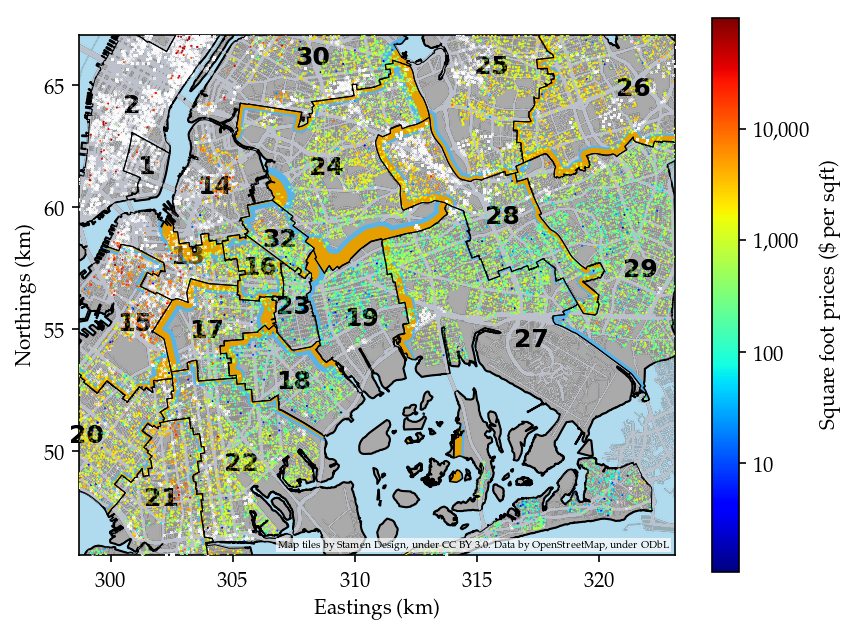

In [119]:
plt.gcf()[:set_size_inches](7.0, 5.0)
NYC.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)
_xlim = plt.xlim()
_ylim = plt.ylim()
NYC.plot_all_pairs(τpost_pairs, nyc_rd; 
    scaleup=5000.0, zorder=5)
plt.xlim(_xlim)
plt.ylim(_ylim)
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204))
plt.text(0.99, 0.01, "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL",
    horizontalalignment="right",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca()[:transAxes], zorder=42)
if do_savefig
    plt.savefig(joinpath(figures_dir, "pairwise_mean_se.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "pairwise_mean_se.png"), bbox_inches="tight")
end
;

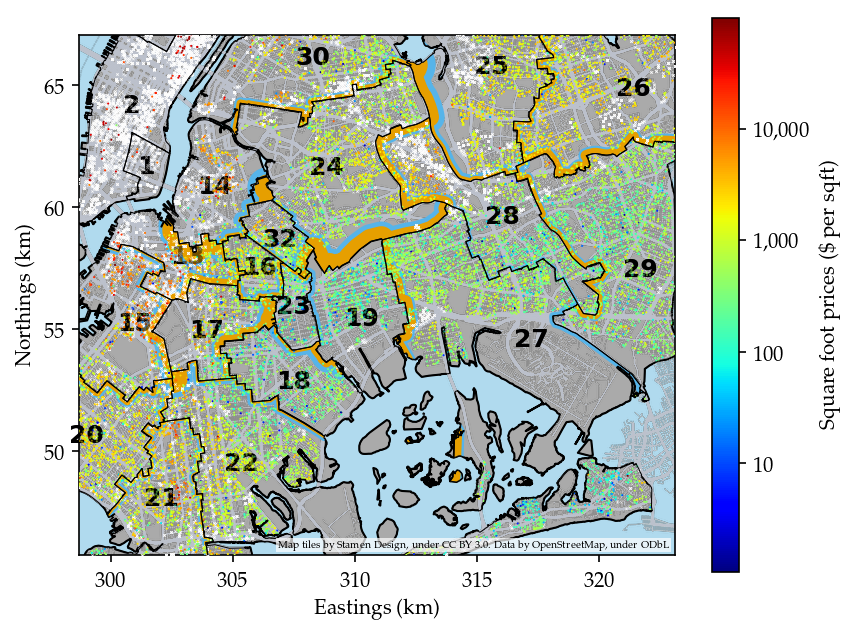

In [127]:
plt.gcf()[:set_size_inches](7.0, 5.0)
NYC.plot_sales(filtered[:filtered], missing_sqft; colorbar=true)
_xlim = plt.xlim()
_ylim = plt.ylim()
NYC.plot_all_pairs(τpost_pairs, nyc_rd; 
    scaleup=5000.0, zorder=5)
plt.xlim(_xlim)
plt.ylim(_ylim)
NYC.plot_streets(; zoom=12, rgb=(188, 193, 204))
plt.text(0.99, 0.01, "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL",
    horizontalalignment="right",
    verticalalignment="bottom",
    fontsize=5,
    bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
    transform = plt.gca()[:transAxes], zorder=42)
if do_savefig
    plt.savefig(joinpath(figures_dir, "pairwise_mean_se.pdf"), bbox_inches="tight")
    plt.savefig(joinpath(figures_dir, "pairwise_mean_se.png"), bbox_inches="tight")
end
;

In [130]:
exp(mean(τpost_pairs[(29,26)]))

0.8574359697760867

In [131]:
exp(mean(τpost_pairs[(26,29)]))

1.1662678441879955

In [137]:
function perc_inc(from_distr, to_distr)
    100*(exp(mean(τpost_pairs[to_distr, from_distr]))-1)
end

perc_inc (generic function with 1 method)

In [152]:
perc_inc(29,26)

16.626784418799545

In [140]:
perc_inc(18, 17)

17.07069298111097

In [142]:
perc_inc(19, 24)

39.95286389044834

In [134]:
include_distr = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]
NYC.table_τpair(τpost_pairs, include_distr)

\( \mathbf{13} \)& \( \mathbf{14:}~-0.30 \pm 0.10 \)& \( \mathbf{15:}~+0.05 \pm 0.08 \)& \( \mathbf{16:}~-0.07 \pm 0.07 \)& \( \mathbf{17:}~-0.16 \pm 0.09 \)\\ 
\( \mathbf{14} \)& \( \mathbf{13:}~+0.30 \pm 0.10 \)& \( \mathbf{16:}~-0.07 \pm 0.12 \)& \( \mathbf{24:}~-0.35 \pm 0.19 \)& \( \mathbf{32:}~-0.04 \pm 0.13 \)\\ 
\( \mathbf{15} \)& \( \mathbf{13:}~-0.05 \pm 0.08 \)& \( \mathbf{17:}~-0.18 \pm 0.11 \)& \( \mathbf{20:}~+0.09 \pm 0.06 \)& \( \mathbf{22:}~+0.40 \pm 0.14 \)\\ 
\( \mathbf{16} \)& \( \mathbf{13:}~+0.07 \pm 0.07 \)& \( \mathbf{14:}~+0.07 \pm 0.12 \)& \( \mathbf{17:}~-0.08 \pm 0.08 \)& \( \mathbf{23:}~-0.10 \pm 0.08 \)& \( \mathbf{32:}~+0.04 \pm 0.08 \)\\ 
\( \mathbf{17} \)& \( \mathbf{13:}~+0.16 \pm 0.09 \)& \( \mathbf{15:}~+0.18 \pm 0.11 \)& \( \mathbf{16:}~+0.08 \pm 0.08 \)& \( \mathbf{18:}~-0.16 \pm 0.07 \)& \( \mathbf{22:}~+0.06 \pm 0.08 \)& \( \mathbf{23:}~-0.29 \pm 0.11 \)\\ 
\( \mathbf{18} \)& \( \mathbf{17:}~+0.16 \pm 0.07 \)& \( \mathbf{19:}~-0.13 \pm 0.14 \)& \